## Import

In [272]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [273]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [274]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [275]:
torch.cuda.is_available()

True

In [276]:
torch.__version__

'2.0.1+cu118'

In [277]:
# torch.cuda.empty_cache()

## Hyperparameter Setting

In [278]:
CFG = {
    'TRAIN_WINDOW_SIZE':120, # 90일치로 학습  초기는 90일이였음 
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':100,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4096,
    'SEED':41
}

In [279]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 불러오기

In [280]:
train_data = pd.read_csv('E:/LG/LG_data/train.csv')

In [281]:
brand_keyword_cnt = pd.read_csv('E:/LG/LG_data/brand_keyword_cnt.csv')

# EDA

In [282]:
train_data.head(2)

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0


###  <<<<하고 싶은 EDA>>>>

### 먼저 데이터의 분포를 알고 싶은 그래서 대분류 중분류 소분류의 브랜드을 엮을 생각임 
### ex) 대분류, 브랜등 // 대분류 중분류 브랜드 등등 
### 규칙성이 있다면 규칙성이 있는 것 끼리 묶어서 학습을 시키고 싶음

### ==========================================================================

### <<<교수님께 질문 할 것>>>



## 지금 아이디어 


## EDA 일부 해본 결과 이상치를 제거해서 한번 해보는 것이 좋지 않을까 생각중ㅇ이다. 이상치를 제가히면 더 좋지 않을까?? 

In [283]:
train_data.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [284]:
brand_keyword_cnt.head()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.450530,2.422390,1.871190,1.581080,1.232950,1.174930,1.145920,...,0.319110,0.391640,0.377130,0.49318,0.072520,0.29010,0.31911,0.232080,0.333620,0.44966
1,B002-00002,12.64868,20.27850,15.332170,12.750210,13.562510,13.707570,11.937910,15.564250,14.084710,...,10.269790,11.966920,10.646930,10.41485,10.487380,9.48651,9.28343,10.429350,11.154620,11.38671
2,B002-00003,0.33362,0.43516,0.362630,0.174060,0.217580,0.464170,0.420650,0.290100,0.377130,...,0.536690,0.696250,0.449660,0.39164,1.029880,0.49318,0.91383,0.797790,1.015370,0.88482
3,B002-00005,1.07339,1.71163,2.016240,1.914700,1.987230,2.146790,1.682620,1.378000,1.421520,...,2.219320,2.509420,2.872060,2.37888,2.030750,1.53756,1.34899,1.261960,2.320850,2.30635
4,B002-00006,0.00000,0.00000,0.188558,0.246574,0.246574,0.246574,0.377139,0.087012,0.261084,...,0.072526,0.290103,0.087012,0.00000,0.130542,0.00000,0.00000,0.072526,0.217577,0.00000


In [285]:
sales = pd.read_csv("E:/LG/LG_data/sales.csv")

In [286]:
feature = ["브랜드"]

## 이거 재미있다 배웠다.

In [287]:
import pandas as pd

# sales.csv 파일을 읽어옵니다.
sales = pd.read_csv("E:/LG/LG_data/sales.csv").drop(columns=["ID", '제품', "대분류",
                                                            "중분류", "소분류"])

# 나머지 열의 값을 10000으로 나누어 "sales_divided" 데이터프레임에 저장합니다.
sales_divided = sales.iloc[:, 1:] / 10000

# "브랜드" 열을 추출합니다.
brands = sales["브랜드"]

# "브랜드" 열을 "sales_divided" 데이터프레임의 첫 번째 열로 추가합니다.
sales_divided.insert(0, "브랜드", brands)

# 결과를 확인합니다.
sales_divided.tail()


,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15885,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
15886,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.069,0.0,4.046,8.092,2.023,2.023,6.069
15887,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
15888,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,2.730
15889,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000


In [288]:
sales_divided.tail()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15885,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
15886,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.069,0.0,4.046,8.092,2.023,2.023,6.069
15887,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000
15888,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,2.730
15889,B002-03799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000


### sales 와 train은 완벽하게 연관성을 갖고 있다 이 두가지 데이터를 잘 이용하면 좋은 결과를 얻을 수 있지 않을까?? 그래서 생각한 것은 둘다 학습을 시키고 그것의 이용하면 좋을꺼 같은데 음......고민된다. 아니먄 이상치라도 다 제거해버려??

이상치를 제거하는 것이 의미가 있을지 모르겠다.. 이 데이터를 보면 이상치 제거가 목적이 아니지 않을까?? 이상치를 잡기보다는 음.... 규칙성을 잘 잡을 수 있게 학습을 하는 것이 더욱 좋을 것이라고 보여진다.

## train and brand key word 시각화

In [289]:
brand_keyword_cnts = pd.read_csv("E:/LG/LG_data/brand_keyword_cnt.csv")

brand_keyword_cntss = brand_keyword_cnts.iloc[:,1: :] * 3

brand = brand_keyword_cnts["브랜드"]

brand_keyword_cntss.insert(0, "브랜드", brand)

brand_keyword_cntss.head()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,2.52393,2.74149,4.351590,7.267170,5.613570,4.743240,3.698850,3.524790,3.437760,...,0.957330,1.17492,1.131390,1.47954,0.217560,0.87030,0.95733,0.696240,1.000860,1.34898
1,B002-00002,37.94604,60.83550,45.996510,38.250630,40.687530,41.122710,35.813730,46.692750,42.254130,...,30.809370,35.90076,31.940790,31.24455,31.462140,28.45953,27.85029,31.288050,33.463860,34.16013
2,B002-00003,1.00086,1.30548,1.087890,0.522180,0.652740,1.392510,1.261950,0.870300,1.131390,...,1.610070,2.08875,1.348980,1.17492,3.089640,1.47954,2.74149,2.393370,3.046110,2.65446
3,B002-00005,3.22017,5.13489,6.048720,5.744100,5.961690,6.440370,5.047860,4.134000,4.264560,...,6.657960,7.52826,8.616180,7.13664,6.092250,4.61268,4.04697,3.785880,6.962550,6.91905
4,B002-00006,0.00000,0.00000,0.565673,0.739721,0.739721,0.739721,1.131417,0.261037,0.783251,...,0.217577,0.87031,0.261037,0.00000,0.391625,0.00000,0.00000,0.217577,0.652732,0.00000


## train과  key_word_count연관성이 딱히 없음

## 하나만 본거지만 대분류, 중분류, 소분류, 브랜드를 통해서 같은 체널에서 같은 브랜드의 제품을 팔았을때 판매량이 감소하는 경향성이 있음 // 즉 제품은 다르지만 경향성 측면에서는 존재하는 것 같다.  // <가설> 감소하는 이유는 아마도 해 당 채널의 광고가 감소또는 그 채널의 기능이 점차 약해지는 것이 아닐지 유추 해본다.

## 확실히 같은 채녈 , 같은브랜드는 연관성이 있다!!! 물론 전부는 아니지만 묶어서 학습하면 좋을 듯 // 제품에 따라서 일부 차이가 있지만 판매량이 제로인 시기만 봐도 그 채널 또는 브랜드가 일시적 죽는 현상을 확인 가능

In [290]:
train_data.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [291]:
sales_divided_11 = train_data[train_data['ID'] == 0 ].iloc[:, 350 : 464]
sales_divided_11.head()

,2022-12-11,2022-12-12,2022-12-13,2022-12-14,2022-12-15,2022-12-16,2022-12-17,2022-12-18,2022-12-19,2022-12-20,...,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03
0,0,5,0,4,0,2,0,5,5,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\User\AppData\Local\Temp\ipykernel_42544\1279774614.py:24: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\1279774614.py:24: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\1279774614.py:24: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\1279774614.py:24: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\1279774614.py:24: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\1279774614.py:24: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:

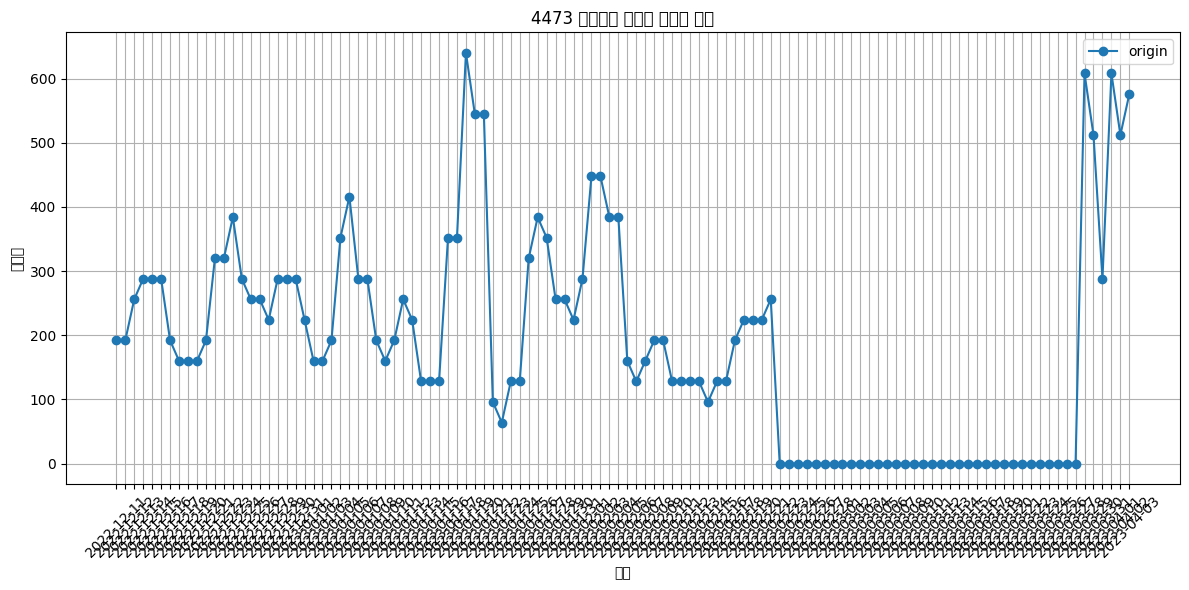

In [292]:
import pandas as pd
import matplotlib.pyplot as plt

target_brand = 4473

sales_divided_11 = train_data[train_data['ID'] == target_brand ].iloc[:, 350 : 464]  #144  420 :464


# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))

plt.plot(sales_divided_11.columns, sales_divided_11.values[0], marker='o', linestyle='-', label = "origin")
# 

plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
                                     i                       i

In [ ]:
                                                                    i                             i

## 대부분의 데이터가 마지막 부분 70일 부분 판매량이 제로에 가까움 // 의도한 걸까??/ 아니면 학습에 별로이기 때문에 제거하고 돌려보자

04470

## resent // 1d 2d 차이 2d도 시계열에 사용가능한지 // 그룹화 해서 학습시키는 것

## <궁금한것 생김>

## 이 데이터 22년 1월 1일 부터 120 일 치 분석일지 4월4일 - 120 분석일까 나는 후자가 무조건 맞다고 보거든 아닐수도 있을니까 찾자 -> 찾아 본 결과 후자로 학습을 진행함 

## ========================================================================

# 9월 10일 : EDA 연구 // 가설 가능성 정리해보자 //

In [293]:
section =train_data[train_data['브랜드'] == 'B002-00028']
section.head()

sales_divided_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
& (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
& (train_data['브랜드'] == 'B002-03463')]


In [295]:
sales_divided_11 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
& (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
& (train_data['브랜드'] == 'B002-03463')]


sales_divided_11.head()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
14676,B002-03463-00008,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,1,...,0,0,0,0,0,0,2,0,2,0
14677,B002-03463-00009,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14678,B002-03463-00012,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14679,B002-03463-00013,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14680,B002-03463-00015,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03463,0,0,0,0,0,...,0,0,0,6,0,0,23,0,0,2


In [342]:

sales_divided_22 = train_data[(train_data['대분류'] == 'B002-C001-0005') 
& (train_data['중분류'] == 'B002-C002-0011')& (train_data['소분류'] == 'B002-C003-0053') 
& (train_data['브랜드'] == 'B002-03528')]


sales_divided_22.head()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
14884,B002-03528-00004,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03528,0,0,0,0,0,...,0,0,0,16,8,12,12,9,18,5
14885,B002-03528-00010,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03528,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14886,B002-03528-00012,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03528,0,0,0,0,0,...,0,0,0,22,14,15,6,0,14,16
14887,B002-03528-00013,B002-C001-0005,B002-C002-0011,B002-C003-0053,B002-03528,0,0,0,0,0,...,0,0,0,12,5,6,8,6,11,12


In [182]:
brand_keyword_cnt= pd.read_csv('E:\\LG\\LG_data\\brand_keyword_cnt.csv')
brand_keyword_cnt.head()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.450530,2.422390,1.871190,1.581080,1.232950,1.174930,1.145920,...,0.319110,0.391640,0.377130,0.49318,0.072520,0.29010,0.31911,0.232080,0.333620,0.44966
1,B002-00002,12.64868,20.27850,15.332170,12.750210,13.562510,13.707570,11.937910,15.564250,14.084710,...,10.269790,11.966920,10.646930,10.41485,10.487380,9.48651,9.28343,10.429350,11.154620,11.38671
2,B002-00003,0.33362,0.43516,0.362630,0.174060,0.217580,0.464170,0.420650,0.290100,0.377130,...,0.536690,0.696250,0.449660,0.39164,1.029880,0.49318,0.91383,0.797790,1.015370,0.88482
3,B002-00005,1.07339,1.71163,2.016240,1.914700,1.987230,2.146790,1.682620,1.378000,1.421520,...,2.219320,2.509420,2.872060,2.37888,2.030750,1.53756,1.34899,1.261960,2.320850,2.30635
4,B002-00006,0.00000,0.00000,0.188558,0.246574,0.246574,0.246574,0.377139,0.087012,0.261084,...,0.072526,0.290103,0.087012,0.00000,0.130542,0.00000,0.00000,0.072526,0.217577,0.00000


In [183]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# 원래 데이터를 로드
original_data = pd.read_csv('E:\\LG\\LG_data\\brand_keyword_cnt.csv').drop(columns = ["브랜드"])

# RobustScaler로 스케일링된 데이터를 로드
brand_keyword_cnt = pd.read_csv('E:\\LG\\LG_data\\brand_keyword_cnt.csv').drop(columns = ["브랜드"])

# 스케일링할 때 사용한 RobustScaler 객체 생성
scaler = RobustScaler()

# 스케일러를 원래 데이터에 맞게 fit (중앙값과 IQR을 계산)
scaler.fit(original_data)

# 역 스케일링 수행
restored_data = pd.DataFrame(scaler.inverse_transform(brand_keyword_cnt), columns=brand_keyword_cnt.columns)

# 복원된 데이터를 확인

restored_data.head()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,1.681299,2.077956,3.811030,6.179343,4.919246,4.456060,3.326646,2.627668,2.859851,3.667453,...,0.908209,1.422688,1.394721,1.566241,0.648306,1.009543,0.870005,0.758823,1.286797,1.525184
1,21.206084,38.734336,35.424244,30.298520,32.392328,34.182864,27.550151,29.657214,30.073749,40.870146,...,18.373225,28.037723,25.154999,23.153811,22.931316,19.218345,16.345446,18.804524,26.086906,26.273869
2,0.841777,1.171857,1.333512,0.928683,1.033477,1.718074,1.488549,0.965563,1.242870,2.480126,...,1.290096,2.123077,1.562527,1.345310,2.696616,1.411640,1.896693,1.759937,2.849266,2.509877
3,2.065068,3.588152,5.099344,4.993704,5.191925,5.842838,4.344173,3.009124,3.439515,7.085496,...,4.243378,6.292098,7.167008,5.669147,4.838018,3.479502,2.647926,2.581360,5.841230,5.726558
4,0.290100,0.348120,0.937090,1.098028,1.101609,1.184659,1.390091,0.584074,0.998792,1.436711,...,0.475414,1.189224,0.723503,0.493180,0.772446,0.435148,0.319114,0.476466,1.020845,0.507680


In [185]:
brand_keyword_cnt= pd.read_csv('E:\\LG\\LG_data\\brand_keyword_cnt.csv')
brand_keyword_cnt.head()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.450530,2.422390,1.871190,1.581080,1.232950,1.174930,1.145920,...,0.319110,0.391640,0.377130,0.49318,0.072520,0.29010,0.31911,0.232080,0.333620,0.44966
1,B002-00002,12.64868,20.27850,15.332170,12.750210,13.562510,13.707570,11.937910,15.564250,14.084710,...,10.269790,11.966920,10.646930,10.41485,10.487380,9.48651,9.28343,10.429350,11.154620,11.38671
2,B002-00003,0.33362,0.43516,0.362630,0.174060,0.217580,0.464170,0.420650,0.290100,0.377130,...,0.536690,0.696250,0.449660,0.39164,1.029880,0.49318,0.91383,0.797790,1.015370,0.88482
3,B002-00005,1.07339,1.71163,2.016240,1.914700,1.987230,2.146790,1.682620,1.378000,1.421520,...,2.219320,2.509420,2.872060,2.37888,2.030750,1.53756,1.34899,1.261960,2.320850,2.30635
4,B002-00006,0.00000,0.00000,0.188558,0.246574,0.246574,0.246574,0.377139,0.087012,0.261084,...,0.072526,0.290103,0.087012,0.00000,0.130542,0.00000,0.00000,0.072526,0.217577,0.00000


In [186]:
brand = brand_keyword_cnt["브랜드"]
restored_data.insert(0, "브랜드", brand)
restored_data.head()

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,1.681299,2.077956,3.811030,6.179343,4.919246,4.456060,3.326646,2.627668,2.859851,...,0.908209,1.422688,1.394721,1.566241,0.648306,1.009543,0.870005,0.758823,1.286797,1.525184
1,B002-00002,21.206084,38.734336,35.424244,30.298520,32.392328,34.182864,27.550151,29.657214,30.073749,...,18.373225,28.037723,25.154999,23.153811,22.931316,19.218345,16.345446,18.804524,26.086906,26.273869
2,B002-00003,0.841777,1.171857,1.333512,0.928683,1.033477,1.718074,1.488549,0.965563,1.242870,...,1.290096,2.123077,1.562527,1.345310,2.696616,1.411640,1.896693,1.759937,2.849266,2.509877
3,B002-00005,2.065068,3.588152,5.099344,4.993704,5.191925,5.842838,4.344173,3.009124,3.439515,...,4.243378,6.292098,7.167008,5.669147,4.838018,3.479502,2.647926,2.581360,5.841230,5.726558
4,B002-00006,0.290100,0.348120,0.937090,1.098028,1.101609,1.184659,1.390091,0.584074,0.998792,...,0.475414,1.189224,0.723503,0.493180,0.772446,0.435148,0.319114,0.476466,1.020845,0.507680


In [188]:
train_data.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0,1,6,37,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,1,1,2,7,43,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.333333,0.222222,0.0,0.0,0.222222,0.0
2,2,2,2,7,43,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,3,3,2,7,43,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,4,4,0,0,2,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


C:\Users\User\AppData\Local\Temp\ipykernel_42544\3187091047.py:26: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\3187091047.py:26: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\3187091047.py:26: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\3187091047.py:26: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\3187091047.py:26: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_42544\3187091047.py:26: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:

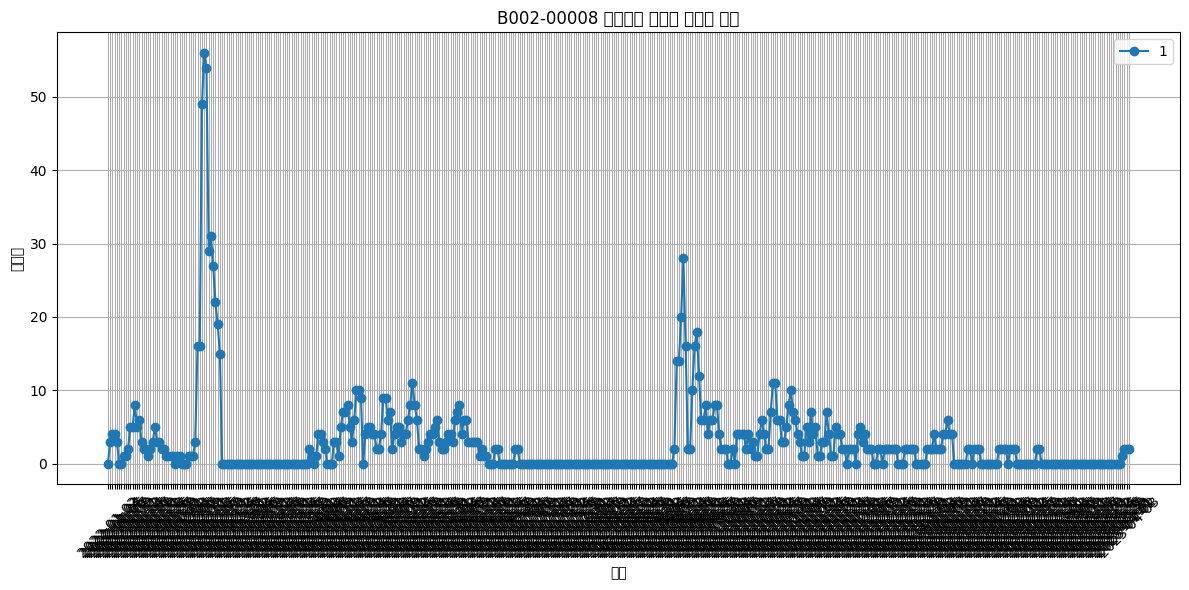

In [298]:
import pandas as pd
import matplotlib.pyplot as plt

target_brand = 'B002-00008'

sales_divided_11 = train_data[train_data['브랜드'] == target_brand ].iloc[:, 7 : 464]  #144  420 :464

# sales_divided_12 = restored_data[restored_data['브랜드'] == target_brand ].iloc[:, 100 : 464]

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))

plt.plot(sales_divided_11.columns, sales_divided_11.values[0], marker='o', linestyle='-', label = "1")
# plt.plot(sales_divided_12.columns, sales_divided_12.values[0], marker='o', linestyle='-', label = "2")
# 

plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 이상치 제거

### <구상>

### 우선 0을 제외한 숫자의 합의 평균을 구하고 그리고 표준편차를 구해서 빼고 이상치는 그 전 값으로 바꾸기

In [101]:
train_data.head()

,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [208]:
brand_keyword_cnt.head(2)

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.45053,2.42239,1.87119,1.58108,1.23295,1.17493,1.14592,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671


In [267]:
numeric_cols = train_data.columns[6:]

# 칵 column의 min 및 max 계산
upper = train_data[numeric_cols].mean(axis=1) + train_data[numeric_cols].std(axis=1) * 10
lower = train_data[numeric_cols].mean(axis=1) - train_data[numeric_cols].std(axis=1) * 10


# 이상치 식별
outliers_upper = train_data[numeric_cols].gt(upper, axis=0)
outliers_lower = train_data[numeric_cols].lt(lower, axis=0)

# print(outliers_upper)


# 이상치가 있는 행 확인
outliers_upper_any = outliers_upper.any(axis=1)
outliers_lower_any = outliers_lower.any(axis=1)

# 결과 출력
print(outliers_upper_any)
print(outliers_lower_any)

# 이상치를 upper 값으로 대체
train_data.loc[outliers_upper_any, numeric_cols] = upper

import pandas as pd

# 원본 데이터와 합치기
original_data = pd.read_csv('E:/LG/LG_data/train.csv') # 원본 데이터 불러오기
original_data[numeric_cols] = train_data[numeric_cols]  # 숫자 열을 이상치가 대체된 값으로 업데이트

# 이상치가 대체된 데이터를 저장
original_data.to_csv('E:/LG/LG_data/original_data.csv', index=False)


143      False
240      False
407      False
513      False
696      False
         ...  
14506    False
14736    False
14831    False
15501    False
15577    False
Length: 85, dtype: bool
143      False
240      False
407      False
513      False
696      False
         ...  
14506    False
14736    False
14831    False
15501    False
15577    False
Length: 85, dtype: bool


In [268]:
original_data.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
import pandas as pd

# 더 작은 값을 추가하여 분모가 0인 경우 방지하는 상수 정의

numeric_cols = train_data.columns[6:]

# 칵 column의 min 및 max 계산

upper =  train_data[numeric_cols].mean(axis=1) + train_data[numeric_cols].std(axis=1) *5
lower =  train_data[numeric_cols].mean(axis=1) - train_data[numeric_cols].std(axis=1) *5

print(lower)
print(upper)

# 이상치 식별
outliers = (train_data[numeric_cols] > upper[:, np.newaxis])| (train_data[numeric_cols] < lower[:, np.newaxis])

import numpy as np

# 이상치를 상한치로 대체
train_data[numeric_cols] = np.where(outliers, upper[:, None].astype(np.float32), train_data[numeric_cols])

# 이상치를 하한치로 대체
train_data[numeric_cols] = np.where(outliers, lower[:, None].astype(np.float32), train_data[numeric_cols])



# 대체된 데이터 확인|
print(train_data[numeric_cols])


# # 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 EPSILON 더해주기
# ranges = max_values - min_values + EPSILON

# # min-max scaling 수행
# scaled_data = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)

# # 스케일링된 데이터로 업데이트
# train_data[numeric_cols] = scaled_data

# # max와 min 값을 dictionary 형태로 저장
# scale_min_dict = min_values.to_dict()
# scale_max_dict = max_values.to_dict()


0         -7.915133
1         -7.027763
2        -16.773217
3        -36.174277
4        -31.166797
            ...    
15885   -124.527403
15886    -46.896550
15887    -23.312469
15888    -11.806276
15889     -0.231201
Length: 15890, dtype: float64
0          9.409686
1          9.589855
2         21.291736
3         43.093667
4         36.504487
            ...    
15885    150.104745
15886     56.016376
15887     31.081533
15888     16.411941
15889      0.235559
Length: 15890, dtype: float64


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

### 데이터 전처리

In [210]:
import pandas as pd

# 더 작은 값을 추가하여 분모가 0인 경우 방지하는 상수 정의
EPSILON = 1e-8

numeric_cols = train_data.columns[6:]

# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)

max_values = train_data[numeric_cols].max(axis=1)


# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 EPSILON 더해주기
ranges = max_values - min_values + EPSILON

# min-max scaling 수행
scaled_data = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)

# 스케일링된 데이터로 업데이트
train_data[numeric_cols] = scaled_data

# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()


In [222]:
max_values.shape

(15890,)

In [310]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ["제품",'대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [328]:
train_data.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0,1,6,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,7,43,1,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,2,2,7,43,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,2,7,43,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,0,0,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [327]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :6]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :6])
        sales_data = np.array(data.iloc[i, 6:])
        
        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [312]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :6]) + 1))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :6])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

In [313]:
train_data.tail()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15885,15885,15835,2,7,41,3169,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,15836,2,7,43,3169,0,0,0,0,...,0,0,0,3,0,2,4,1,1,3
15887,15887,15837,2,7,43,3169,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,15838,2,7,43,3169,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
15889,15889,15839,1,3,19,3169,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [314]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

100%|██████████| 15890/15890 [00:10<00:00, 1557.50it/s]


In [329]:
print(train_input.shape)
print(test_input.shape)
print(train_target.shape)
print(len(train_input))
print(len(train_data))

(5164250, 120, 7)
(15890, 120, 7)
(5164250, 21)
5164250
15890


In [331]:
data_len = len(train_input)
val_ratio = 0.1

val_len = int(data_len * val_ratio)


val_input = train_input[-val_len:]
val_target = train_target[-val_len:]

train_input = train_input[:-val_len]
train_target = train_target[:-val_len]


In [332]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((4183043, 120, 7),
 (4183043, 21),
 (464782, 120, 7),
 (464782, 21),
 (15890, 120, 7))

### 라벨이 7개의 예측값을 갖는다

### Custom Dataset

In [335]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [336]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [341]:
import torch

# DataLoader에서 배치 데이터 가져오기 (예: 첫 번째 배치)
for batch in train_loader:
    inputs, targets = batch
    # inputs와 targets은 텐서(Tensor) 객체입니다.
    # 이곳에서 배치 데이터를 확인하고 분석할 수 있습니다.
    print(inputs.shape)  # 입력 데이터의 크기 출력
    print(targets.shape)  # 타겟 데이터의 크기 출력
    break  # 첫 번째 배치만 확인


torch.Size([4096, 120, 7])
torch.Size([4096, 21])


### 모델 선언

# Layer Normalization

In [224]:
class ImprovedModelWithCNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=512, num_layers=3, output_size=CFG['PREDICT_SIZE'], dropout_prob=0.2):
        super(ImprovedModelWithCNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 1D CNN 레이어 추가
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, hidden_size, kernel_size=20, padding=1, stride=1),  # 1D 합성곱 레이어
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=1),  # 맥스 풀링 레이어
            nn.Conv1d(hidden_size, hidden_size, kernel_size=10, padding=1, stride=1),  # 추가 합성곱 레이어
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=1),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 5, padding =1, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1) # 추가 맥스 풀링 레이어
        )
        
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.ln = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # 1D CNN 레이어 적용
        x = self.cnn(x.permute(0, 2, 1)).permute(0, 2, 1)

        # permute(0, 2, 1): 데이터의 차원을 변경합니다. 
        # 기존의 [batch_size, seq_length, input_size] 차원에서 
        # [batch_size, input_size, seq_length]로 변경합니다. 

        gru_out, hidden = self.gru(x, hidden)
        gru_out = self.dropout(gru_out)
        gru_out = self.ln(gru_out)  # Layer Normalization 적용

        last_output = gru_out[:, -1, :]
        
        # [:, -1, :]: 첫 번째 차원의 모든 요소 (batch 차원)를 선택하고, 두 번째 차원에서는
        # -1 인덱스를 사용하여 마지막 타임 스텝의 히든 상태를 선택하고, 
        # 세 번째 차원에서는 모든 요소 (특성 차원)를 선택합니다

        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)


In [ ]:
# Recurrent Neural Network (RNN) 레이어 또는 Gated Recurrent Unit
# (GRU) 레이어와 같은 순환 뉴럴 네트워크를 사용할 때, 이 네트워크는 
# 시간 단계별로 정보를 처리하고 각 시간 단계에서 내부 숨겨진 상태를 유지합니다. 
# 시퀀스의 각 요소 또는 타임 스텝에서 입력이 처리될 때마다 숨겨진 상태가 갱신되고
# 새로운 정보를 수용합니다.

# 마지막 타임 스텝의 히든 상태는 시퀀스 데이터의 모든 요소 또는 타임 스텝을 처리한 
# 후의 상태를 나타냅니다. 이는 모델이 시퀀스 데이터의 내용을 요약한 표현으로 사용될 수 있으며,
# 다음 단계에서 예측이나 분류를 수행하는 데 사용될 수 있습니다. 이것은 RNN 또는 GRU와 같은 
# 순환 레이어를 사용하는 시퀀스 모델에서 중요한 개념입니다.

### 모델 학습

In [225]:
def train(model, optimizer, train_loader, val_loader, device, scheduler=None):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = float('inf')
    best_model = None
    early_stopping_counter = 0
    max_early_stopping = 10  # Max number of consecutive epochs with increasing validation loss
    
    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []
        train_mae = []

        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())


        
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if scheduler is not None:
            scheduler.step(val_loss)  # Update learning rate based on scheduler's policy
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= max_early_stopping:
                print(f'Early stopping triggered at epoch {epoch}')
                break

    return best_model


In [226]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

## Run !!

In [37]:
import torch.optim.lr_scheduler as lr_scheduler

model = ImprovedModel() # BaseModel() 
optimizer = torch.optim.RAdam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.7, verbose=True)
infer_model = train(model, optimizer, train_loader, val_loader, device, scheduler)


100%|██████████| 126/126 [00:28<00:00,  4.44it/s]


Epoch : [1] Train Loss : [0.03244] Val Loss : [0.02965]


100%|██████████| 126/126 [00:28<00:00,  4.43it/s]


Epoch : [2] Train Loss : [0.03041] Val Loss : [0.03081]


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [3] Train Loss : [0.02909] Val Loss : [0.02969]
Epoch 00003: reducing learning rate of group 0 to 7.0000e-05.


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [4] Train Loss : [0.02816] Val Loss : [0.02954]


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [5] Train Loss : [0.02770] Val Loss : [0.03008]


100%|██████████| 126/126 [00:27<00:00,  4.50it/s]


Epoch : [6] Train Loss : [0.02476] Val Loss : [0.01791]


100%|██████████| 126/126 [00:27<00:00,  4.52it/s]


Epoch : [7] Train Loss : [0.01737] Val Loss : [0.01757]


100%|██████████| 126/126 [00:27<00:00,  4.64it/s]


Epoch : [8] Train Loss : [0.01701] Val Loss : [0.01704]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [9] Train Loss : [0.01697] Val Loss : [0.01661]


100%|██████████| 126/126 [00:27<00:00,  4.61it/s]


Epoch : [10] Train Loss : [0.01682] Val Loss : [0.01810]


100%|██████████| 126/126 [00:27<00:00,  4.64it/s]


Epoch : [11] Train Loss : [0.01676] Val Loss : [0.01643]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [12] Train Loss : [0.01646] Val Loss : [0.01679]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [13] Train Loss : [0.01638] Val Loss : [0.01614]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [14] Train Loss : [0.01637] Val Loss : [0.01640]


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


Epoch : [15] Train Loss : [0.01632] Val Loss : [0.01612]


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


Epoch : [16] Train Loss : [0.01625] Val Loss : [0.01610]


100%|██████████| 126/126 [00:27<00:00,  4.59it/s]


Epoch : [17] Train Loss : [0.01623] Val Loss : [0.01657]


100%|██████████| 126/126 [00:27<00:00,  4.60it/s]


Epoch : [18] Train Loss : [0.01619] Val Loss : [0.01629]
Epoch 00018: reducing learning rate of group 0 to 4.9000e-05.


100%|██████████| 126/126 [00:28<00:00,  4.45it/s]


Epoch : [19] Train Loss : [0.01606] Val Loss : [0.01621]


100%|██████████| 126/126 [00:27<00:00,  4.65it/s]


Epoch : [20] Train Loss : [0.01611] Val Loss : [0.01696]
Epoch 00020: reducing learning rate of group 0 to 3.4300e-05.


100%|██████████| 126/126 [00:28<00:00,  4.45it/s]


Epoch : [21] Train Loss : [0.01606] Val Loss : [0.01616]


100%|██████████| 126/126 [00:28<00:00,  4.46it/s]


Epoch : [22] Train Loss : [0.01594] Val Loss : [0.01603]


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [23] Train Loss : [0.01589] Val Loss : [0.01607]


100%|██████████| 126/126 [00:28<00:00,  4.44it/s]


Epoch : [24] Train Loss : [0.01584] Val Loss : [0.01611]
Epoch 00024: reducing learning rate of group 0 to 2.4010e-05.


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [25] Train Loss : [0.01577] Val Loss : [0.01617]


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


Epoch : [26] Train Loss : [0.01573] Val Loss : [0.01616]
Epoch 00026: reducing learning rate of group 0 to 1.6807e-05.


100%|██████████| 126/126 [00:26<00:00,  4.68it/s]


Epoch : [27] Train Loss : [0.01568] Val Loss : [0.01624]


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


Epoch : [28] Train Loss : [0.01565] Val Loss : [0.01631]
Epoch 00028: reducing learning rate of group 0 to 1.1765e-05.


100%|██████████| 126/126 [00:28<00:00,  4.43it/s]


Epoch : [29] Train Loss : [0.01561] Val Loss : [0.01640]


100%|██████████| 126/126 [00:28<00:00,  4.48it/s]


Epoch : [30] Train Loss : [0.01559] Val Loss : [0.01642]
Epoch 00030: reducing learning rate of group 0 to 8.2354e-06.


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


Epoch : [31] Train Loss : [0.01555] Val Loss : [0.01637]


100%|██████████| 126/126 [00:28<00:00,  4.47it/s]

Epoch : [32] Train Loss : [0.01554] Val Loss : [0.01670]
Epoch 00032: reducing learning rate of group 0 to 5.7648e-06.
Early stopping triggered at epoch 32


## 모델 추론

In [38]:
test_dataset = CustomDataset(test_input, None)

# test_dataset은 추론을 위한 데이터셋 객체입니다.
# 이 데이터셋은 모델을 평가할 때 사용될 입력 데이터를 포함하고 있으며,
# 라벨(정답)은 필요하지 않기 때문에 None으로 설정되었습니다.
# 이렇게 하면 test_dataset은 입력 데이터만 포함하게 됩니다.

test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [39]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
            # predictions.extend(output) 코드는
            # output 배열의 내용을 predictions 리스트에 추가하는 것을 의미합니다
    
    return np.array(predictions)

## my_list = [1, 2, 3, 4, 5]
## my_array = np.array(my_list)
## array([1, 2, 3, 4, 5])

In [40]:
pred = inference(infer_model, test_loader, device)

100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


In [41]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [42]:
pred.shape

(15890, 21)

## Submission

In [52]:
submit = pd.read_csv('E:/LG/LG_data/sample_submission.csv')
submit.tail()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
15885,15885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15887,15887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15889,15889,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
submit.to_csv('E:/LG/LG_data/models/baseline_submit_epoch_23_130_4096_512_RAdam_GRUNOnozition_2_LAYER_2_774999489560.3.csv', index=False)